# TFM

data: https://drive.google.com/drive/folders/1fx_j6gmiATvhEaBtUwEPuCOl8peJ2zDM

## Import packages and knn_lib

In [1]:
import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import time
import statistics as st
import distance

from ipynb.fs.full.knn_lib import *

### Euclidean distance

In [72]:
# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return math.sqrt(distance)

#### Time comparison

In [73]:
row0 = df_tstrss_DSI1[0]
start = time.time()
for row in df_trnrss_DSI1:
    euclidean_distance(row0, row)
end = time.time()
print(end - start)

NameError: name 'df_tstrss_DSI1' is not defined

In [ ]:
a = np.array(df_tstrss_DSI1[0])
b = np.array(df_trnrss_DSI1)
start = time.time()
for row in b:
    np.linalg.norm(a-b)
end = time.time()
print(end - start)

In [ ]:
start = time.time()
for row in df_trnrss_DSI1:
    np.sqrt(np.sum(np.square(a-b)))
end = time.time()
print(end - start)

In [3]:
from scipy.spatial import distance
start = time.time()
for row in df_trnrss_DSI1:
    distance.euclidean(row0, row)
end = time.time()
print(end - start)

NameError: name 'df_trnrss_DSI1' is not defined

In [53]:
# WINNER
start = time.time()
for row in df_trnrss_DSI1:
    math.dist(row0, row)
end = time.time()
print(end - start)

0.013959169387817383


### Calculations

In [4]:
#start = time.time()
k=1
k1_DSI1 = positioning_error(k, "DSI1")
k1_DSI2 = positioning_error(k, "DSI2")
k1_LIB1 = positioning_error(k, "LIB1")
k1_LIB2 = positioning_error(k, "LIB2")
#k1_MAN1 = positioning_error(k, "MAN1")
k1_MAN2 = positioning_error(k, "MAN2")
#k1_SIM001 = positioning_error(k, "SIM001")

k=5
k5_DSI1 = positioning_error(k, "DSI1")
k5_DSI2 = positioning_error(k, "DSI2")
k5_LIB1 = positioning_error(k, "LIB1")
k5_LIB2 = positioning_error(k, "LIB2")
#k5_MAN1 = positioning_error(k, "MAN1")
k5_MAN2 = positioning_error(k, "MAN2")
#k5_SIM001 = positioning_error(k, "SIM001")

k=11
k11_DSI1 = positioning_error(k, "DSI1")
k11_DSI2 = positioning_error(k, "DSI2")
k11_LIB1 = positioning_error(k, "LIB1")
k11_LIB2 = positioning_error(k, "LIB2")
#k11_MAN1 = positioning_error(k, "MAN1")
k11_MAN2 = positioning_error(k, "MAN2")
#k11_SIM001 = positioning_error(k, "SIM001")

#end = time.time()
#print(end - start)

### ECDF

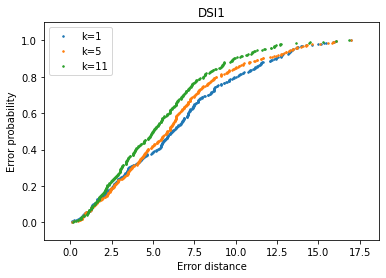

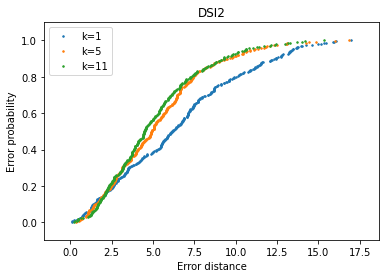

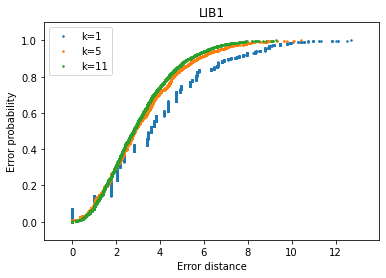

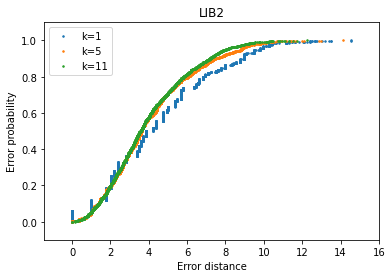

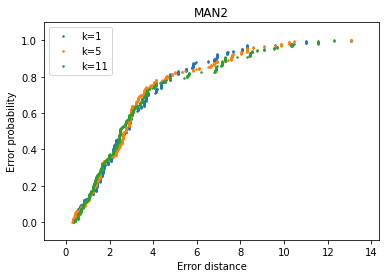

In [11]:
plot_ecdf("DSI1", 1, ["k=1", "k=5", "k=11"], k1_DSI1, k5_DSI1, k11_DSI1)
plot_ecdf("DSI2", 2, ["k=1", "k=5", "k=11"], k1_DSI2, k5_DSI2, k11_DSI2)
plot_ecdf("LIB1", 3, ["k=1", "k=5", "k=11"], k1_LIB1, k5_LIB1, k11_LIB1)
plot_ecdf("LIB2", 4, ["k=1", "k=5", "k=11"], k1_LIB2, k5_LIB2, k11_LIB2)
plot_ecdf("MAN2", 5, ["k=1", "k=5", "k=11"], k1_MAN2, k5_MAN2, k11_MAN2)

### Execution time for knn and prediction

In [6]:
k = 1

# calculate knn and predict positions
start = time.time()
positions_DSI1 = knn_and_prediction(k, "DSI1")
end = time.time()
print("DSI1: {}".format(end - start))

start = time.time()
positions_DSI2 = knn_and_prediction(k, "DSI2")
end = time.time()
print("DSI2: {}".format(end - start))

start = time.time()
positions_LIB1 = knn_and_prediction(k,"LIB1")
end = time.time()
print("LIB1: {}".format(end - start))

start = time.time()
positions_LIB2 = knn_and_prediction(k,"LIB2")
end = time.time()
print("LIB2: {}".format(end - start))

start = time.time()
positions_MAN1 = knn_and_prediction(k,"MAN1")
end = time.time()
print("MAN1: {}".format(end - start))

start = time.time()
positions_MAN2 = knn_and_prediction(k,"MAN2")
end = time.time()
print("MAN2: {}".format(end - start))

start = time.time()
positions_SIM001 = knn_and_prediction(k,"SIM001")
end = time.time()
print("SIM001: {}".format(end - start))

DSI1: 3.1834843158721924
DSI2: 1.3005192279815674
LIB1: 15.171459913253784
LIB2: 18.078359603881836
MAN1: 31.907597303390503
MAN2: 2.7416670322418213
SIM001: 43.50564169883728


### Calculate average error

In [8]:
# calculate average error from lists of positioning errors
print("DSI1: {}".format(avg_error(k11_DSI1)))
print("DSI2: {}".format(avg_error(k11_DSI2)))
print("LIB1: {}".format(avg_error(k11_LIB1)))
print("LIB2: {}".format(avg_error(k11_LIB2)))
#print("MAN1: {}".format(avg_error(k1_MAN1)))
print("MAN2: {}".format(avg_error(k11_MAN2)))
#print("SIM001: {}".format(avg_error(k1_SIM001)))

DSI1: 5.38
DSI2: 5.04
LIB1: 3.03
LIB2: 3.95
MAN2: 3.4


### Distance measures comparison on DSI1 average error with k=1

#### Basic

In [5]:
k=1
print_postitioning_errors(k, "DSI1", distance_metrics, norm=False, abs_value=False, increment=False)

euclidean: 6.46
minkowskiL1: 6.38
minkowskiL2: 6.46
minkowskiL3: 6.56
minkowskiL4: 6.47
minkowskiL5: 6.53
cityblock: 6.38
chebyshev: 21.18
sorensen: 26.65
gower: 6.38
soergel: 6.35
kulczynski_d: 6.35
lorentzian: 5.91
canberra: 6.42
intersection: 6.38
wavehedges: 6.94
czekanowski_s: 6.35
czekanowski_d: 41.46
motyka_s: 6.35
motyka_d: 41.46
kulczynski_s: 6.35
ruzicka: 6.35
tanimoto: 6.35
inner: 48.84
harmonic: 7.52
cosine: 6.46
kumar: 6.46
jaccard_s: 6.46
jaccard_d: 49.36
dice_s: 6.46
dice_d: 49.36


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:377: RuntimeWarning: invalid value encountered in sqrt
  "metadata": {},


fidelity: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:381: RuntimeWarning: invalid value encountered in sqrt
  },


bhattacharrya: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:385: RuntimeWarning: invalid value encountered in sqrt
  "metadata": {},


hellinger: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:389: RuntimeWarning: invalid value encountered in sqrt
  "factor=1e-7\n",


hellinger2: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:393: RuntimeWarning: invalid value encountered in sqrt
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


matusita: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:397: RuntimeWarning: invalid value encountered in sqrt
  "def soergel(P, Q):\n",


matusita2: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:401: RuntimeWarning: invalid value encountered in sqrt
  "\n",


squared_chord: 35.61
sqeuclidean: 6.46
pearson: 40.68
neyman: 57.31
squared: 7.6
prob_sym: 7.6
divergence: 10.43
clark: 10.43
additive_sym: 53.98


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:433: RuntimeWarning: invalid value encountered in log
  "def motyka_d(P, Q):\n",


kullback_PQ: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:441: RuntimeWarning: invalid value encountered in log
  "    if A != 0:\n",


jeffreys: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:445: RuntimeWarning: invalid value encountered in log
  "    return dist\n",


k_divergence: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:449: RuntimeWarning: invalid value encountered in log
  "    maxPQ=sum(np.maximum(P,Q))\n",


topsoe: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:453: RuntimeWarning: invalid value encountered in log
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


jensen_shannon: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:457: RuntimeWarning: invalid value encountered in log
  "def harmonic(P, Q):\n",


jensen_diff: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:461: RuntimeWarning: invalid value encountered in sqrt
  "def kumar(P, Q):\n",
C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:461: RuntimeWarning: invalid value encountered in log
  "def kumar(P, Q):\n",


taneja: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:465: RuntimeWarning: invalid value encountered in power
  "def jaccard_s(P, Q):\n",


kumar_johnson: 35.61
avgL: 6.41
vicis_wave_hedges: 52.23
vicis_symm1: 6.39
vicis_symm2: 51.43
vicis_symm3: 6.51
min_symm: 53.19
max_symm: 52.22


#### Normalized

In [2]:
k=1
print_postitioning_errors(k, "DSI1", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 6.52
minkowskiL1: 6.34
minkowskiL2: 6.52
minkowskiL3: 6.59
minkowskiL4: 6.49
minkowskiL5: 6.48
cityblock: 6.34
chebyshev: 21.76
sorensen: 25.76
gower: 6.34
soergel: 6.28
kulczynski_d: 6.28
lorentzian: 6.18
canberra: 5.82
intersection: 6.34
wavehedges: 5.83
czekanowski_s: 6.28
czekanowski_d: 46.62
motyka_s: 6.28
motyka_d: 46.62
kulczynski_s: 6.28
ruzicka: 6.28
tanimoto: 6.28
inner: 39.32
harmonic: 28.16
cosine: 6.43
kumar: 6.73
jaccard_s: 6.73
jaccard_d: 39.25
dice_s: 6.47
dice_d: 45.94
fidelity: 40.14
bhattacharrya: 40.53


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:407: RuntimeWarning: invalid value encountered in sqrt
  "metadata": {},


hellinger: 35.61
hellinger2: 6.44


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:415: RuntimeWarning: invalid value encountered in sqrt
  "metadata": {},


matusita: 35.61
matusita2: 6.44
squared_chord: 6.44
sqeuclidean: 6.52
pearson: 16.38
neyman: 13.51
squared: 6.47
prob_sym: 6.47
divergence: 6.36
clark: 6.36
additive_sym: 11.81
kullback_PQ: 24.71
jeffreys: 6.94
k_divergence: 39.94
topsoe: 6.46
jensen_shannon: 6.46
jensen_diff: 6.46
taneja: 7.33
kumar_johnson: 15.08
avgL: 6.35
vicis_wave_hedges: 12.87
vicis_symm1: 15.49
vicis_symm2: 12.98
vicis_symm3: 6.27
min_symm: 15.07
max_symm: 12.81


#### Absolute value WINNER

In [3]:
k=1
print_postitioning_errors(k, "DSI1", distance_metrics, norm=False, abs_value=True, increment=False)

euclidean: 5.04
minkowskiL1: 4.95
minkowskiL2: 5.04
minkowskiL3: 5.58
minkowskiL4: 6.25
minkowskiL5: 6.62
cityblock: 4.95
chebyshev: 7.67
sorensen: 26.65
gower: 4.95
soergel: 4.99
kulczynski_d: 4.99
lorentzian: 5.66
canberra: 4.8
intersection: 4.95
wavehedges: 4.7
czekanowski_s: 4.99
czekanowski_d: 51.34
motyka_s: 4.99
motyka_d: 51.34
kulczynski_s: 4.99
ruzicka: 4.99
tanimoto: 4.99
inner: 40.68
harmonic: 57.31
cosine: 5.06
kumar: 5.1
jaccard_s: 5.1
jaccard_d: 46.01
dice_s: 5.1
dice_d: 46.01
fidelity: 40.68
bhattacharrya: 57.31


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:407: RuntimeWarning: invalid value encountered in sqrt
  "metadata": {},


hellinger: 35.61
hellinger2: 5.01


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:415: RuntimeWarning: invalid value encountered in sqrt
  "metadata": {},


matusita: 35.61
matusita2: 5.01
squared_chord: 5.01
sqeuclidean: 5.04
pearson: 5.11
neyman: 4.87
squared: 5.01
prob_sym: 5.01
divergence: 4.77
clark: 4.77
additive_sym: 4.99
kullback_PQ: 57.31
jeffreys: 5.0
k_divergence: 57.31
topsoe: 5.01
jensen_shannon: 5.01
jensen_diff: 5.01
taneja: 5.0
kumar_johnson: 4.98
avgL: 4.97
vicis_wave_hedges: 4.76
vicis_symm1: 4.9
vicis_symm2: 4.91
vicis_symm3: 5.02
min_symm: 4.98
max_symm: 5.02


#### Increment

In [3]:
k=1
print_postitioning_errors(k, "DSI1", distance_metrics, norm=False, abs_value=False, increment=True)

euclidean: 6.46
minkowskiL1: 6.38
minkowskiL2: 6.46
minkowskiL3: 6.56
minkowskiL4: 6.47
minkowskiL5: 6.53
cityblock: 6.38
chebyshev: 21.18
sorensen: 26.65
gower: 6.38
soergel: 6.28
kulczynski_d: 6.28
lorentzian: 5.91
canberra: 5.81
intersection: 6.38
wavehedges: 5.77
czekanowski_s: 6.28
czekanowski_d: 47.32
motyka_s: 6.28
motyka_d: 47.32
kulczynski_s: 6.28
ruzicka: 6.28
tanimoto: 6.28
inner: 39.76
harmonic: 28.73
cosine: 6.42
kumar: 6.51
jaccard_s: 6.51
jaccard_d: 47.16
dice_s: 6.51
dice_d: 47.16
fidelity: 40.56
bhattacharrya: 41.54


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:411: RuntimeWarning: invalid value encountered in sqrt
  "\n",


hellinger: 35.61
hellinger2: 6.29


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:419: RuntimeWarning: invalid value encountered in sqrt
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


matusita: 35.61
matusita2: 6.29
squared_chord: 6.29
sqeuclidean: 6.46
pearson: 13.91
neyman: 8.75
squared: 6.45
prob_sym: 6.45
divergence: 6.09
clark: 6.09
additive_sym: 7.34
kullback_PQ: 24.84
jeffreys: 6.52
k_divergence: 42.63
topsoe: 6.39
jensen_shannon: 6.39
jensen_diff: 6.39
taneja: 6.61
kumar_johnson: 8.35
avgL: 6.41
vicis_wave_hedges: 7.18
vicis_symm1: 10.25
vicis_symm2: 7.24
vicis_symm3: 6.43
min_symm: 12.52
max_symm: 8.46


#### Absolute value k=3, k=5, k=11

In [2]:
k=3
print_postitioning_errors(k, "DSI1", distance_metrics, norm=False, abs_value=True, increment=False)

euclidean: 5.13
minkowskiL1: 4.95
minkowskiL2: 5.13
minkowskiL3: 5.59
minkowskiL4: 6.14
minkowskiL5: 6.46
cityblock: 4.95
chebyshev: 7.57
sorensen: 26.17
gower: 4.95
soergel: 4.98
kulczynski_d: 4.98
lorentzian: 5.55
canberra: 4.65
intersection: 4.95
wavehedges: 4.69
czekanowski_s: 4.98
czekanowski_d: 51.18
motyka_s: 4.98
motyka_d: 51.18
kulczynski_s: 4.98
ruzicka: 4.98
tanimoto: 4.98
inner: 40.68
harmonic: 57.31
cosine: 5.12
kumar: 5.18
jaccard_s: 5.18
jaccard_d: 46.13
dice_s: 5.18
dice_d: 46.13
fidelity: 40.68
bhattacharrya: 57.31


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:386: RuntimeWarning: invalid value encountered in sqrt
  "def kulczynski_d(P, Q):\n",


hellinger: 35.61
hellinger2: 5.14


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:394: RuntimeWarning: invalid value encountered in sqrt
  "\n",


matusita: 35.61
matusita2: 5.14
squared_chord: 5.14
sqeuclidean: 5.13
pearson: 5.14
neyman: 4.89
squared: 5.14
prob_sym: 5.14
divergence: 4.8
clark: 4.8
additive_sym: 5.07
kullback_PQ: 57.31
jeffreys: 5.12
k_divergence: 57.31
topsoe: 5.14
jensen_shannon: 5.14
jensen_diff: 5.14
taneja: 5.11
kumar_johnson: 5.08
avgL: 4.91
vicis_wave_hedges: 4.66
vicis_symm1: 4.98
vicis_symm2: 5.02
vicis_symm3: 5.09
min_symm: 5.07
max_symm: 5.11


In [13]:
k=5
print_postitioning_errors(k, "DSI1", distance_metrics, norm=False, abs_value=False, increment=True)

euclidean: 6.13
minkowskiL1: 5.95
minkowskiL2: 6.13
minkowskiL3: 6.27
minkowskiL4: 6.18
minkowskiL5: 6.23
cityblock: 5.95
chebyshev: 22.08
sorensen: 24.98
gower: 5.95
soergel: 5.86
kulczynski_d: 5.86
lorentzian: 5.55
canberra: 5.3
intersection: 5.95
wavehedges: 5.37
czekanowski_s: 5.86
czekanowski_d: 45.89
motyka_s: 5.86
motyka_d: 45.89
kulczynski_s: 5.86
ruzicka: 5.86
tanimoto: 5.86
inner: 39.65
harmonic: 25.41
cosine: 6.02
kumar: 6.04
jaccard_s: 6.04
jaccard_d: 45.71
dice_s: 6.04
dice_d: 45.71
fidelity: 40.84
bhattacharrya: 34.07


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:493: RuntimeWarning: invalid value encountered in sqrt
  "def kulczynski_d(P, Q):\n",


hellinger: 35.83
hellinger2: 6.05


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:501: RuntimeWarning: invalid value encountered in sqrt
  "\n",


matusita: 35.83
matusita2: 6.05
squared_chord: 6.05
sqeuclidean: 6.13
pearson: 14.02
neyman: 8.27
squared: 6.14
prob_sym: 6.14
divergence: 5.77
clark: 5.77
additive_sym: 7.04
kullback_PQ: 23.29
jeffreys: 6.13
k_divergence: 34.99
topsoe: 6.07
jensen_shannon: 6.07
jensen_diff: 6.07
taneja: 6.25
kumar_johnson: 8.23
avgL: 5.95
vicis_wave_hedges: 6.88
vicis_symm1: 9.97
vicis_symm2: 7.18
vicis_symm3: 6.03
min_symm: 12.65
max_symm: 7.53


In [15]:
k=11
print_postitioning_errors(k, "DSI1", distance_metrics, norm=False, abs_value=False, increment=True)

euclidean: 5.38
minkowskiL3: 5.42
minkowskiL4: 5.52
minkowskiL5: 5.62
cityblock: 5.11
chebyshev: 24.39
sorensen: 24.31
gower: 5.11
soergel: 5.12
kulczynski_d: 5.12
lorentzian: 4.84
canberra: 4.74
intersection: 5.11
wavehedges: 4.75
czekanowski_s: 5.12
czekanowski_d: 43.95
motyka_s: 5.12
motyka_d: 43.95
kulczynski_s: 5.12
ruzicka: 5.12
tanimoto: 5.12
inner: 36.56
harmonic: 24.86
cosine: 5.35
kumar: 5.34
jaccard_s: 5.34
jaccard_d: 43.66
dice_s: 5.34
dice_d: 43.67
fidelity: 36.24
bhattacharrya: 33.37
hellinger2: 5.39
matusita2: 5.39
squared_chord: 5.39
sqeuclidean: 5.38
pearson: 13.34
neyman: 7.42
squared: 5.35
prob_sym: 5.35
divergence: 5.17
clark: 5.17
additive_sym: 6.55
kullback_PQ: 23.42
jeffreys: 5.59
k_divergence: 33.47
topsoe: 5.36
jensen_shannon: 5.36
jensen_diff: 5.36
taneja: 5.68
kumar_johnson: 7.79
avgL: 5.11
vicis_wave_hedges: 6.55
vicis_symm1: 9.73
vicis_symm2: 6.76
vicis_symm3: 5.26
min_symm: 11.44
max_symm: 6.72


In [14]:
# all distance metrics accepted
distance_metrics = ["euclidean", "minkowskiL3", "minkowskiL4", "minkowskiL5", "cityblock",
                    "chebyshev", "sorensen", "gower", "soergel", "kulczynski_d", "lorentzian", "canberra", "intersection",
                    "wavehedges", "czekanowski_s", "czekanowski_d", "motyka_s", "motyka_d", "kulczynski_s", "ruzicka",
                    "tanimoto", "inner", "harmonic", "cosine", "kumar", "jaccard_s", "jaccard_d", "dice_s", "dice_d",
                    "fidelity", "bhattacharrya", "hellinger2", "matusita2", "squared_chord",
                    "sqeuclidean", "pearson", "neyman", "squared", "prob_sym", "divergence", "clark", "additive_sym",
                    "kullback_PQ", "jeffreys", "k_divergence", "topsoe", "jensen_shannon", "jensen_diff", "taneja",
                    "kumar_johnson", "avgL", "vicis_wave_hedges", "vicis_symm1", "vicis_symm2", "vicis_symm3", "min_symm",
                    "max_symm"]

#### ECDF

In [16]:
k=1
k1_euc = positioning_error(k, "DSI1", "euclidean", norm=False, isAbs=False, incr=True)
k1_gow = positioning_error(k, "DSI1", "gower", norm=False, isAbs=False, incr=True)
k1_wave = positioning_error(k, "DSI1", "wavehedges", norm=False, isAbs=False, incr=True)
k=5
k5_euc = positioning_error(k, "DSI1", "euclidean", norm=False, isAbs=False, incr=True)
k5_gow = positioning_error(k, "DSI1", "gower", norm=False, isAbs=False, incr=True)
k5_wave = positioning_error(k, "DSI1", "wavehedges", norm=False, isAbs=False, incr=True)
k=11
k11_euc = positioning_error(k, "DSI1", "euclidean", norm=False, isAbs=False, incr=True)
k11_gow = positioning_error(k, "DSI1", "gower", norm=False, isAbs=False, incr=True)
k11_wave = positioning_error(k, "DSI1", "wavehedges", norm=False, isAbs=False, incr=True)

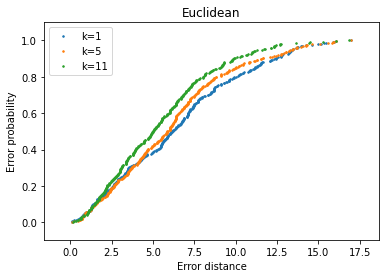

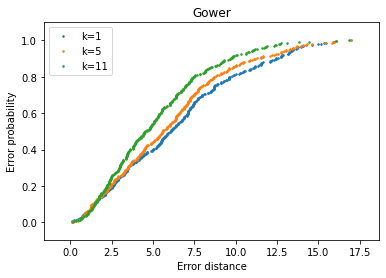

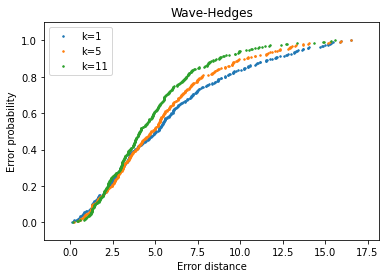

In [18]:
plot_ecdf("Euclidean", 1, ["k=1", "k=5", "k=11"], k1_euc, k5_euc, k11_euc)
plot_ecdf("Gower", 2, ["k=1", "k=5", "k=11"], k1_gow, k5_gow, k11_gow)
plot_ecdf("Wave-Hedges", 3, ["k=1", "k=5", "k=11"], k1_wave, k5_wave, k11_wave)

#### Ensembles

In [2]:
k=11
euc = knn_and_prediction(k, "DSI1", "euclidean", norm=False, isAbs=False, incr=True)
gow = knn_and_prediction(k, "DSI1", "gower", norm=False, isAbs=False, incr=True)
wave = knn_and_prediction(k, "DSI1", "wavehedges", norm=False, isAbs=False, incr=True)

In [4]:
ens = error_ensemble2(k, "DSI1", euc, gow, wave)
euc_e = calculate_error(euc, load_tstcrd("DSI1"))
gow_e = calculate_error(gow, load_tstcrd("DSI1"))
wave_e = calculate_error(wave, load_tstcrd("DSI1"))

In [5]:
print("Median error ensemble DSI1: {}".format(median(ens)))
print("Median error euclidean DSI1: {}".format(median(euc_e)))
print("Median error gower DSI1: {}".format(median(gow_e)))
print("Median error wave hedges DSI1: {}".format(median(wave_e)))

Median error ensemble DSI1: 4.56
Median error euclidean DSI1: 5.01
Median error gower DSI1: 4.58
Median error wave hedges DSI1: 4.1


In [6]:
k=11
euc_1 = knn_and_prediction(k, "DSI1", "euclidean", norm=False, isAbs=False, incr=True)
gow_1 = knn_and_prediction(k, "DSI1", "gower", norm=False, isAbs=False, incr=True)
wave_1 = knn_and_prediction(k, "DSI1", "wavehedges", norm=False, isAbs=False, incr=True)

euc_2 = knn_and_prediction(k, "DSI2", "euclidean", norm=False, isAbs=False, incr=True)
gow_2 = knn_and_prediction(k, "DSI2", "gower", norm=False, isAbs=False, incr=True)
wave_2 = knn_and_prediction(k, "DSI2", "wavehedges", norm=False, isAbs=False, incr=True)

euc_3 = knn_and_prediction(k, "LIB1", "euclidean", norm=False, isAbs=False, incr=True)
gow_3 = knn_and_prediction(k, "LIB1", "gower", norm=False, isAbs=False, incr=True)
wave_3 = knn_and_prediction(k, "LIB1", "wavehedges", norm=False, isAbs=False, incr=True)

euc_4 = knn_and_prediction(k, "LIB2", "euclidean", norm=False, isAbs=False, incr=True)
gow_4 = knn_and_prediction(k, "LIB2", "gower", norm=False, isAbs=False, incr=True)
wave_4 = knn_and_prediction(k, "LIB2", "wavehedges", norm=False, isAbs=False, incr=True)

euc_5 = knn_and_prediction(k, "MAN2", "euclidean", norm=False, isAbs=False, incr=True)
gow_5 = knn_and_prediction(k, "MAN2", "gower", norm=False, isAbs=False, incr=True)
wave_5 = knn_and_prediction(k, "MAN2", "wavehedges", norm=False, isAbs=False, incr=True)

ens1 = error_ensemble2(k, "DSI1", euc_1, gow_1, wave_1)
ens2 = error_ensemble2(k, "DSI2", euc_2, gow_2, wave_2)
ens3 = error_ensemble2(k, "LIB1", euc_3, gow_3, wave_3)
ens4 = error_ensemble2(k, "LIB2", euc_4, gow_4, wave_4)
ens5 = error_ensemble2(k, "MAN2", euc_5, gow_4, wave_5)

In [24]:
k=11
#ens_i_3 = error_ensemble2(k, "DSI1", euc_i, gow_i, wave_i)
#ens_i_euc_gow = error_ensemble2(k, "DSI1", euc_i, gow_i)
#ens_i_euc_wave = error_ensemble2(k, "DSI1", euc_i, wave_i)
#ens_i_gow_wave = error_ensemble2(k, "DSI1", gow_i, wave_i)
#euc_i = calculate_error(euc_i, load_tstcrd("DSI1"))
#gow_i = calculate_error(gow_i, load_tstcrd("DSI1"))
#wave_i = calculate_error(wave_i, load_tstcrd("DSI1"))

Median error ensemble DSI1: 4.56
Median error ensemble DSI2: 4.27
Median error ensemble LIB1: 2.62
Median error ensemble LIB2: 3.5
Median error ensemble MAN2: 10.36


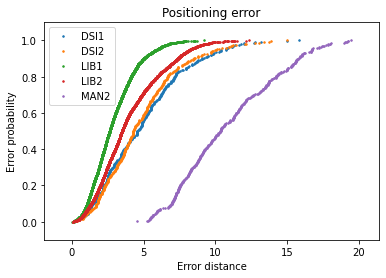

In [7]:
#print("Average error euclidean: {}".format(avg_error(euc_i)))
#print("Average error gower: {}".format(avg_error(gow_i)))
#print("Average error wave-hedges: {}".format(avg_error(wave_i)))
print("Median error ensemble DSI1: {}".format(median(ens1)))
print("Median error ensemble DSI2: {}".format(median(ens2)))
print("Median error ensemble LIB1: {}".format(median(ens3)))
print("Median error ensemble LIB2: {}".format(median(ens4)))
print("Median error ensemble MAN2: {}".format(median(ens5)))
#print("Average error ensemble Euclidean-Gower: {}".format(avg_error(ens_i_euc_gow)))
#print("Average error ensemble Euclidean-Wave Hedges: {}".format(avg_error(ens_i_euc_wave)))
#print("Average error ensemble Gower-Wave Hedges: {}".format(avg_error(ens_i_gow_wave)))

#scatter(ens_i_3, euc_i, "ensemble vs euclidean", "ensemble", "euclidean")
#scatter(ens_i_3, gow_i, "ensemble vs gower", "ensemble", "gower")
#scatter(ens_i_3, wave_i, "ensemble vs wave hedges", "ensemble", "wave hedges")
plot_ecdf("Positioning error", 1, ["DSI1", "DSI2", "LIB1", "LIB2", "MAN2"], ens1, ens2, ens3, ens4, ens5)

6.14
4.96
4.72
4.5


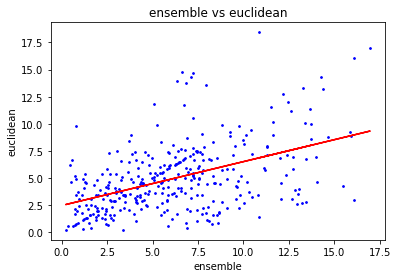

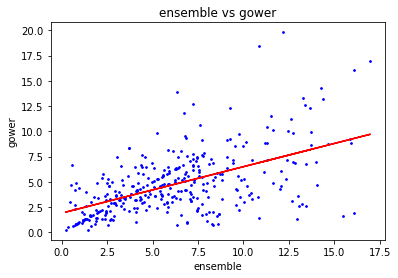

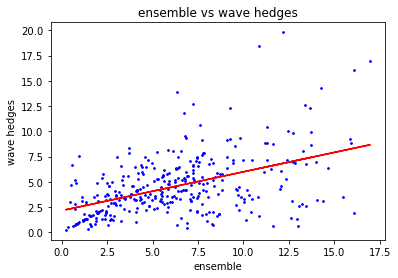

In [70]:
print(avg_error(ens1_a))
print(avg_error(euc_a))
print(avg_error(gow_a))
print(avg_error(wave_a))
scatter(ens1_a, euc_a, "ensemble vs euclidean", "ensemble", "euclidean")
scatter(ens1_a, gow_a, "ensemble vs gower", "ensemble", "gower")
scatter(ens1_a, wave_a, "ensemble vs wave hedges", "ensemble", "wave hedges")

### Distance measures comparison on DSI2 average error with k=1

#### Basic

In [4]:
k=1
print_postitioning_errors(k, "DSI2", distance_metrics, norm=False, abs_value=False, increment=False)

euclidean: 6.46
minkowskiL1: 6.38
minkowskiL2: 6.46
minkowskiL3: 6.56
minkowskiL4: 6.47
minkowskiL5: 6.53
cityblock: 6.38
chebyshev: 21.18
sorensen: 26.65
gower: 6.38
soergel: 6.35
kulczynski_d: 6.35
lorentzian: 5.91
canberra: 6.42
intersection: 6.38
wavehedges: 6.94
czekanowski_s: 6.35
czekanowski_d: 41.46
motyka_s: 6.35
motyka_d: 41.46
kulczynski_s: 6.35
ruzicka: 6.35
tanimoto: 6.35
inner: 48.84
harmonic: 7.52
cosine: 6.46
kumar: 6.46
jaccard_s: 6.46
jaccard_d: 49.36
dice_s: 6.46
dice_d: 49.36


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:403: RuntimeWarning: invalid value encountered in sqrt
  {


fidelity: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:407: RuntimeWarning: invalid value encountered in sqrt
  "outputs": [],


bhattacharrya: 35.61
hellinger: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:415: RuntimeWarning: invalid value encountered in sqrt
  "    A=sum(abs(P-Q))\n",


hellinger2: 35.61
matusita: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:423: RuntimeWarning: invalid value encountered in sqrt
  "def kulczynski_d(P, Q):\n",


matusita2: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:427: RuntimeWarning: invalid value encountered in sqrt
  "\n",


squared_chord: 35.61
sqeuclidean: 6.46
pearson: 40.68
neyman: 57.31
squared: 7.6
prob_sym: 7.6
divergence: 10.43
clark: 10.43
additive_sym: 53.98


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:459: RuntimeWarning: invalid value encountered in log
  "    minPQ=sum(np.minimum(P,Q))\n",


kullback_PQ: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:467: RuntimeWarning: invalid value encountered in log
  "\n",


jeffreys: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:471: RuntimeWarning: invalid value encountered in log
  "    return 1-sum(np.minimum(P,Q))/maxPQ\n",


k_divergence: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:475: RuntimeWarning: invalid value encountered in log
  "    maxPQ=sum(np.maximum(P,Q))\n",


topsoe: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:479: RuntimeWarning: invalid value encountered in log
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


jensen_shannon: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:483: RuntimeWarning: invalid value encountered in log
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


jensen_diff: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:487: RuntimeWarning: invalid value encountered in sqrt
  "    return kumar(P, Q)\n",
C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:487: RuntimeWarning: invalid value encountered in log
  "    return kumar(P, Q)\n",


taneja: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:491: RuntimeWarning: invalid value encountered in power
  "\n",


kumar_johnson: 35.61
avgL: 6.41
vicis_wave_hedges: 52.23
vicis_symm1: 6.39
vicis_symm2: 51.43
vicis_symm3: 6.51
min_symm: 53.19
max_symm: 52.22


#### Normalized

In [5]:
k=1
print_postitioning_errors(k, "DSI2", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 6.52
minkowskiL1: 6.34
minkowskiL2: 6.52
minkowskiL3: 6.59
minkowskiL4: 6.49
minkowskiL5: 6.48
cityblock: 6.34
chebyshev: 21.76
sorensen: 25.76
gower: 6.34
soergel: 6.28
kulczynski_d: 6.28
lorentzian: 6.18
canberra: 5.82
intersection: 6.34
wavehedges: 5.83
czekanowski_s: 6.28
czekanowski_d: 46.62
motyka_s: 6.28
motyka_d: 46.62
kulczynski_s: 6.28
ruzicka: 6.28
tanimoto: 6.28
inner: 39.32
harmonic: 28.16
cosine: 6.43
kumar: 6.73
jaccard_s: 6.73
jaccard_d: 39.25
dice_s: 6.47
dice_d: 45.94
fidelity: 40.14
bhattacharrya: 40.53


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:411: RuntimeWarning: invalid value encountered in sqrt
  "\n",


hellinger: 35.61
hellinger2: 6.44


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:419: RuntimeWarning: invalid value encountered in sqrt
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


matusita: 35.61
matusita2: 6.44
squared_chord: 6.44
sqeuclidean: 6.52
pearson: 16.38
neyman: 13.51
squared: 6.47
prob_sym: 6.47
divergence: 6.36
clark: 6.36
additive_sym: 11.81
kullback_PQ: 24.71
jeffreys: 6.94
k_divergence: 39.94
topsoe: 6.46
jensen_shannon: 6.46
jensen_diff: 6.46
taneja: 7.33
kumar_johnson: 15.08
avgL: 6.35
vicis_wave_hedges: 12.87
vicis_symm1: 15.49
vicis_symm2: 12.98
vicis_symm3: 6.27
min_symm: 15.07
max_symm: 12.81


#### Absolute value WINNER

In [6]:
k=1
print_postitioning_errors(k, "DSI2", distance_metrics, norm=False, abs_value=True, increment=False)

euclidean: 5.04
minkowskiL1: 4.95
minkowskiL2: 5.04
minkowskiL3: 5.58
minkowskiL4: 6.25
minkowskiL5: 6.62
cityblock: 4.95
chebyshev: 7.67
sorensen: 26.65
gower: 4.95
soergel: 4.99
kulczynski_d: 4.99
lorentzian: 5.66
canberra: 4.8
intersection: 4.95
wavehedges: 4.7
czekanowski_s: 4.99
czekanowski_d: 51.34
motyka_s: 4.99
motyka_d: 51.34
kulczynski_s: 4.99
ruzicka: 4.99
tanimoto: 4.99
inner: 40.68
harmonic: 57.31
cosine: 5.06
kumar: 5.1
jaccard_s: 5.1
jaccard_d: 46.01
dice_s: 5.1
dice_d: 46.01
fidelity: 40.68
bhattacharrya: 57.31


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:411: RuntimeWarning: invalid value encountered in sqrt
  "\n",


hellinger: 35.61
hellinger2: 5.01


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:419: RuntimeWarning: invalid value encountered in sqrt
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


matusita: 35.61
matusita2: 5.01
squared_chord: 5.01
sqeuclidean: 5.04
pearson: 5.11
neyman: 4.87
squared: 5.01
prob_sym: 5.01
divergence: 4.77
clark: 4.77
additive_sym: 4.99
kullback_PQ: 57.31
jeffreys: 5.0
k_divergence: 57.31
topsoe: 5.01
jensen_shannon: 5.01
jensen_diff: 5.01
taneja: 5.0
kumar_johnson: 4.98
avgL: 4.97
vicis_wave_hedges: 4.76
vicis_symm1: 4.9
vicis_symm2: 4.91
vicis_symm3: 5.02
min_symm: 4.98
max_symm: 5.02


#### Increment

In [7]:
k=1
print_postitioning_errors(k, "DSI2", distance_metrics, norm=False, abs_value=False, increment=True)

euclidean: 6.46
minkowskiL1: 6.38
minkowskiL2: 6.46
minkowskiL3: 6.56
minkowskiL4: 6.47
minkowskiL5: 6.53
cityblock: 6.38
chebyshev: 21.18
sorensen: 26.65
gower: 6.38
soergel: 6.28
kulczynski_d: 6.28
lorentzian: 5.91
canberra: 5.81
intersection: 6.38
wavehedges: 5.77
czekanowski_s: 6.28
czekanowski_d: 47.32
motyka_s: 6.28
motyka_d: 47.32
kulczynski_s: 6.28
ruzicka: 6.28
tanimoto: 6.28
inner: 39.76
harmonic: 28.73
cosine: 6.42
kumar: 6.51
jaccard_s: 6.51
jaccard_d: 47.16
dice_s: 6.51
dice_d: 47.16
fidelity: 40.56
bhattacharrya: 41.54
hellinger: 35.61
hellinger2: 6.29
matusita: 35.61
matusita2: 6.29
squared_chord: 6.29
sqeuclidean: 6.46
pearson: 13.91
neyman: 8.75
squared: 6.45
prob_sym: 6.45
divergence: 6.09
clark: 6.09
additive_sym: 7.34
kullback_PQ: 24.84
jeffreys: 6.52
k_divergence: 42.63
topsoe: 6.39
jensen_shannon: 6.39
jensen_diff: 6.39
taneja: 6.61
kumar_johnson: 8.35
avgL: 6.41
vicis_wave_hedges: 7.18
vicis_symm1: 10.25
vicis_symm2: 7.24
vicis_symm3: 6.43
min_symm: 12.52
max_sym

#### Absolute value k=3, k=5

In [3]:
k=3
print_postitioning_errors(k, "DSI2", distance_metrics, norm=False, abs_value=True, increment=False)

euclidean: 4.95
minkowskiL1: 4.78
minkowskiL2: 4.95
minkowskiL3: 5.19
minkowskiL4: 5.5
minkowskiL5: 5.62
cityblock: 4.78
chebyshev: 7.08
sorensen: 24.58
gower: 4.78
soergel: 4.8
kulczynski_d: 4.8
lorentzian: 5.32
canberra: 4.57
intersection: 4.78
wavehedges: 4.59
czekanowski_s: 4.8
czekanowski_d: 49.59
motyka_s: 4.8
motyka_d: 49.59
kulczynski_s: 4.8
ruzicka: 4.8
tanimoto: 4.8
inner: 39.24
harmonic: 54.9
cosine: 4.99
kumar: 5.0
jaccard_s: 5.0
jaccard_d: 44.56
dice_s: 5.0
dice_d: 44.56
fidelity: 37.78
bhattacharrya: 55.01
hellinger: 35.79
hellinger2: 4.89
matusita: 35.79
matusita2: 4.89
squared_chord: 4.89
sqeuclidean: 4.95
pearson: 5.01
neyman: 4.67
squared: 4.87
prob_sym: 4.87
divergence: 4.64
clark: 4.64
additive_sym: 4.9
kullback_PQ: 54.9
jeffreys: 4.89
k_divergence: 55.01
topsoe: 4.89
jensen_shannon: 4.89
jensen_diff: 4.89
taneja: 4.9
kumar_johnson: 4.92
avgL: 4.77
vicis_wave_hedges: 4.54
vicis_symm1: 4.84
vicis_symm2: 4.84
vicis_symm3: 4.84
min_symm: 4.85
max_symm: 4.88


In [4]:
k=5
print_postitioning_errors(k, "DSI2", distance_metrics, norm=False, abs_value=True, increment=False)

euclidean: 4.5
minkowskiL1: 4.47
minkowskiL2: 4.5
minkowskiL3: 4.77
minkowskiL4: 4.88
minkowskiL5: 5.13
cityblock: 4.47
chebyshev: 6.54
sorensen: 23.66
gower: 4.47
soergel: 4.47
kulczynski_d: 4.47
lorentzian: 5.62
canberra: 4.33
intersection: 4.47
wavehedges: 4.39
czekanowski_s: 4.47
czekanowski_d: 49.48
motyka_s: 4.47
motyka_d: 49.48
kulczynski_s: 4.47
ruzicka: 4.47
tanimoto: 4.47
inner: 41.36
harmonic: 54.51
cosine: 4.57
kumar: 4.53
jaccard_s: 4.53
jaccard_d: 43.15
dice_s: 4.53
dice_d: 43.15
fidelity: 39.94
bhattacharrya: 54.62
hellinger: 35.95
hellinger2: 4.31
matusita: 35.95
matusita2: 4.31
squared_chord: 4.31
sqeuclidean: 4.5
pearson: 4.59
neyman: 4.2
squared: 4.31
prob_sym: 4.31
divergence: 4.24
clark: 4.24
additive_sym: 4.36
kullback_PQ: 54.52
jeffreys: 4.32
k_divergence: 54.62
topsoe: 4.31
jensen_shannon: 4.31
jensen_diff: 4.31
taneja: 4.33
kumar_johnson: 4.36
avgL: 4.39
vicis_wave_hedges: 4.33
vicis_symm1: 4.42
vicis_symm2: 4.35
vicis_symm3: 4.3
min_symm: 4.44
max_symm: 4.4


In [71]:
k=11
print_postitioning_errors(k, "DSI2", distance_metrics, norm=False, abs_value=True, increment=False)

euclidean: 4.19
minkowskiL1: 4.3
minkowskiL2: 4.18
minkowskiL3: 4.48
minkowskiL4: 4.73
minkowskiL5: 4.81
cityblock: 4.3
chebyshev: 6.12
sorensen: 23.04
gower: 4.3
soergel: 4.33
kulczynski_d: 4.33
lorentzian: 5.83
canberra: 4.3
intersection: 4.3
wavehedges: 4.32
czekanowski_s: 4.33
czekanowski_d: 46.28
motyka_s: 4.33
motyka_d: 46.28
kulczynski_s: 4.33
ruzicka: 4.33
tanimoto: 4.33
inner: 38.84
harmonic: 51.68
cosine: 4.29
kumar: 4.21
jaccard_s: 4.21
jaccard_d: 43.29
dice_s: 4.21
dice_d: 43.29
fidelity: 37.92
bhattacharrya: 51.62


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:461: RuntimeWarning: invalid value encountered in sqrt
  "def kulczynski_d(P, Q):\n",


hellinger: 37.01
hellinger2: 4.14


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:469: RuntimeWarning: invalid value encountered in sqrt
  "\n",


matusita: 37.01
matusita2: 4.14
squared_chord: 4.14
sqeuclidean: 4.18
pearson: 4.36
neyman: 4.14
squared: 4.14
prob_sym: 4.14
divergence: 4.12
clark: 4.12
additive_sym: 4.15
kullback_PQ: 51.67
jeffreys: 4.14
k_divergence: 51.62
topsoe: 4.14
jensen_shannon: 4.14
jensen_diff: 4.14
taneja: 4.14
kumar_johnson: 4.17
avgL: 4.24
vicis_wave_hedges: 4.16
vicis_symm1: 4.22
vicis_symm2: 4.21
vicis_symm3: 4.13
min_symm: 4.26
max_symm: 4.19


### Distance measures comparison on LIB1 average error with k=1

In [8]:
k=1
print_postitioning_errors(k, "LIB1", distance_metrics, norm=False, abs_value=False, increment=False)

euclidean: 3.8
minkowskiL1: 3.61
minkowskiL2: 3.8
minkowskiL3: 3.84
minkowskiL4: 3.86
minkowskiL5: 3.89
cityblock: 3.61
chebyshev: 7.99
sorensen: 8.35
gower: 3.61
soergel: 3.64
kulczynski_d: 3.64
lorentzian: 3.48
canberra: 3.51
intersection: 3.61
wavehedges: 3.91
czekanowski_s: 3.64
czekanowski_d: 11.97
motyka_s: 3.64
motyka_d: 11.97
kulczynski_s: 3.64
ruzicka: 3.64
tanimoto: 3.64
inner: 11.98
harmonic: 4.37
cosine: 3.78
kumar: 3.78
jaccard_s: 3.78
jaccard_d: 11.96
dice_s: 3.78
dice_d: 11.96


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:403: RuntimeWarning: invalid value encountered in sqrt
  {


fidelity: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:407: RuntimeWarning: invalid value encountered in sqrt
  "outputs": [],


bhattacharrya: 10.08
hellinger: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:415: RuntimeWarning: invalid value encountered in sqrt
  "    A=sum(abs(P-Q))\n",


hellinger2: 10.08
matusita: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:423: RuntimeWarning: invalid value encountered in sqrt
  "def kulczynski_d(P, Q):\n",


matusita2: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:427: RuntimeWarning: invalid value encountered in sqrt
  "\n",


squared_chord: 10.08
sqeuclidean: 3.8
pearson: 10.0
neyman: 8.21
squared: 4.32
prob_sym: 4.32
divergence: 5.18
clark: 5.18
additive_sym: 12.46


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:459: RuntimeWarning: invalid value encountered in log
  "    minPQ=sum(np.minimum(P,Q))\n",


kullback_PQ: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:467: RuntimeWarning: invalid value encountered in log
  "\n",


jeffreys: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:471: RuntimeWarning: invalid value encountered in log
  "    return 1-sum(np.minimum(P,Q))/maxPQ\n",


k_divergence: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:475: RuntimeWarning: invalid value encountered in log
  "    maxPQ=sum(np.maximum(P,Q))\n",


topsoe: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:479: RuntimeWarning: invalid value encountered in log
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


jensen_shannon: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:483: RuntimeWarning: invalid value encountered in log
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


jensen_diff: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:487: RuntimeWarning: invalid value encountered in sqrt
  "    return kumar(P, Q)\n",
C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:487: RuntimeWarning: invalid value encountered in log
  "    return kumar(P, Q)\n",


taneja: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:491: RuntimeWarning: invalid value encountered in power
  "\n",


kumar_johnson: 10.08
avgL: 3.61
vicis_wave_hedges: 12.33
vicis_symm1: 3.54
vicis_symm2: 12.34
vicis_symm3: 3.88
min_symm: 9.45
max_symm: 11.02


#### Normalized

In [9]:
k=1
print_postitioning_errors(k, "LIB1", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 3.79
minkowskiL1: 3.6
minkowskiL2: 3.79
minkowskiL3: 3.83
minkowskiL4: 3.85
minkowskiL5: 3.89
cityblock: 3.6
chebyshev: 7.52
sorensen: 7.63
gower: 3.6
soergel: 3.64
kulczynski_d: 3.64
lorentzian: 3.56
canberra: 3.56
intersection: 3.6
wavehedges: 3.5
czekanowski_s: 3.64
czekanowski_d: 11.95
motyka_s: 3.64
motyka_d: 11.95
kulczynski_s: 3.64
ruzicka: 3.64
tanimoto: 3.64
inner: 11.46
harmonic: 5.9
cosine: 3.78
kumar: 11.89
jaccard_s: 11.89
jaccard_d: 3.74
dice_s: 3.78
dice_d: 11.9
fidelity: 10.89
bhattacharrya: 6.48


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:411: RuntimeWarning: invalid value encountered in sqrt
  "\n",


hellinger: 10.08
hellinger2: 3.85


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:419: RuntimeWarning: invalid value encountered in sqrt
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


matusita: 10.08
matusita2: 3.85
squared_chord: 3.85
sqeuclidean: 3.79
pearson: 4.24
neyman: 5.84
squared: 3.75
prob_sym: 3.75
divergence: 3.64
clark: 3.64
additive_sym: 5.05
kullback_PQ: 5.79
jeffreys: 3.97
k_divergence: 6.59
topsoe: 3.8
jensen_shannon: 3.8
jensen_diff: 3.8
taneja: 4.07
kumar_johnson: 5.69
avgL: 3.6
vicis_wave_hedges: 5.19
vicis_symm1: 6.17
vicis_symm2: 5.24
vicis_symm3: 3.67
min_symm: 4.21
max_symm: 5.48


#### Absolute value

In [10]:
k=1
print_postitioning_errors(k, "LIB1", distance_metrics, norm=False, abs_value=True, increment=False)

euclidean: 3.04
minkowskiL1: 3.04
minkowskiL2: 3.05
minkowskiL3: 3.11
minkowskiL4: 3.18
minkowskiL5: 3.21
cityblock: 3.04
chebyshev: 3.79
sorensen: 8.35
gower: 3.04
soergel: 3.03
kulczynski_d: 3.03
lorentzian: 3.39
canberra: 3.05
intersection: 3.04
wavehedges: 3.08
czekanowski_s: 3.03
czekanowski_d: 11.94
motyka_s: 3.03
motyka_d: 11.94
kulczynski_s: 3.03
ruzicka: 3.03
tanimoto: 3.03
inner: 11.01
harmonic: 8.04
cosine: 3.03
kumar: 3.05
jaccard_s: 3.05
jaccard_d: 12.61
dice_s: 3.05
dice_d: 12.61
fidelity: 10.5
bhattacharrya: 8.19


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:411: RuntimeWarning: invalid value encountered in sqrt
  "\n",


hellinger: 10.08
hellinger2: 3.05


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:419: RuntimeWarning: invalid value encountered in sqrt
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


matusita: 10.08
matusita2: 3.05
squared_chord: 3.05
sqeuclidean: 3.05
pearson: 3.06
neyman: 3.03
squared: 3.05
prob_sym: 3.05
divergence: 3.05
clark: 3.05
additive_sym: 3.05
kullback_PQ: 8.06
jeffreys: 3.05
k_divergence: 8.17
topsoe: 3.05
jensen_shannon: 3.05
jensen_diff: 3.05
taneja: 3.05
kumar_johnson: 3.05
avgL: 3.06
vicis_wave_hedges: 3.04
vicis_symm1: 3.06
vicis_symm2: 3.05
vicis_symm3: 3.03
min_symm: 3.03
max_symm: 3.05


#### Increment

In [11]:
k=1
print_postitioning_errors(k, "LIB1", distance_metrics, norm=False, abs_value=False, increment=True)

euclidean: 3.8
minkowskiL1: 3.61
minkowskiL2: 3.8
minkowskiL3: 3.84
minkowskiL4: 3.86
minkowskiL5: 3.89
cityblock: 3.61
chebyshev: 7.99
sorensen: 8.35
gower: 3.61
soergel: 3.61
kulczynski_d: 3.61
lorentzian: 3.48
canberra: 3.49
intersection: 3.61
wavehedges: 3.47
czekanowski_s: 3.61
czekanowski_d: 12.02
motyka_s: 3.61
motyka_d: 12.02
kulczynski_s: 3.61
ruzicka: 3.61
tanimoto: 3.61
inner: 11.42
harmonic: 5.95
cosine: 3.79
kumar: 3.79
jaccard_s: 3.79
jaccard_d: 11.95
dice_s: 3.79
dice_d: 11.95
fidelity: 10.79
bhattacharrya: 6.63
hellinger: 10.08
hellinger2: 3.82
matusita: 10.08
matusita2: 3.82
squared_chord: 3.82
sqeuclidean: 3.8
pearson: 4.17
neyman: 5.02
squared: 3.77
prob_sym: 3.77
divergence: 3.67
clark: 3.67
additive_sym: 4.23
kullback_PQ: 5.82
jeffreys: 3.86
k_divergence: 6.65
topsoe: 3.8
jensen_shannon: 3.8
jensen_diff: 3.8
taneja: 3.91
kumar_johnson: 4.57
avgL: 3.61
vicis_wave_hedges: 4.15
vicis_symm1: 5.18
vicis_symm2: 4.29
vicis_symm3: 3.71
min_symm: 4.14
max_symm: 4.54


#### Absolute value k=3, k=5

In [5]:
k=3
print_postitioning_errors(k, "LIB1", distance_metrics, norm=False, abs_value=True, increment=False)

euclidean: 2.73
minkowskiL1: 2.75
minkowskiL2: 2.73
minkowskiL3: 2.83
minkowskiL4: 2.9
minkowskiL5: 2.94
cityblock: 2.75
chebyshev: 3.49
sorensen: 7.07
gower: 2.75
soergel: 2.75
kulczynski_d: 2.75
lorentzian: 2.96
canberra: 2.75
intersection: 2.75
wavehedges: 2.75
czekanowski_s: 2.75
czekanowski_d: 11.64
motyka_s: 2.75
motyka_d: 11.64
kulczynski_s: 2.75
ruzicka: 2.75
tanimoto: 2.75
inner: 10.54
harmonic: 8.02
cosine: 2.7
kumar: 2.73
jaccard_s: 2.73
jaccard_d: 12.41
dice_s: 2.73
dice_d: 12.41
fidelity: 10.23
bhattacharrya: 8.17
hellinger: 10.08
hellinger2: 2.76
matusita: 10.08
matusita2: 2.76
squared_chord: 2.76
sqeuclidean: 2.73
pearson: 2.79
neyman: 2.75
squared: 2.76
prob_sym: 2.76
divergence: 2.8
clark: 2.8
additive_sym: 2.77
kullback_PQ: 8.07
jeffreys: 2.76
k_divergence: 8.16
topsoe: 2.76
jensen_shannon: 2.76
jensen_diff: 2.76
taneja: 2.77
kumar_johnson: 2.77
avgL: 2.75
vicis_wave_hedges: 2.73
vicis_symm1: 2.84
vicis_symm2: 2.78
vicis_symm3: 2.74
min_symm: 2.73
max_symm: 2.8


In [6]:
k=5
print_postitioning_errors(k, "LIB1", distance_metrics, norm=False, abs_value=True, increment=False)

euclidean: 2.63
minkowskiL1: 2.64
minkowskiL2: 2.63
minkowskiL3: 2.72
minkowskiL4: 2.8
minkowskiL5: 2.86
cityblock: 2.64
chebyshev: 3.39
sorensen: 6.79
gower: 2.64
soergel: 2.63
kulczynski_d: 2.63
lorentzian: 2.83
canberra: 2.65
intersection: 2.64
wavehedges: 2.66
czekanowski_s: 2.63
czekanowski_d: 11.54
motyka_s: 2.63
motyka_d: 11.54
kulczynski_s: 2.63
ruzicka: 2.63
tanimoto: 2.63
inner: 10.16
harmonic: 7.92
cosine: 2.59
kumar: 2.62
jaccard_s: 2.62
jaccard_d: 12.37
dice_s: 2.62
dice_d: 12.37
fidelity: 9.86
bhattacharrya: 8.12
hellinger: 10.08
hellinger2: 2.66
matusita: 10.08
matusita2: 2.66
squared_chord: 2.66
sqeuclidean: 2.63
pearson: 2.69
neyman: 2.67
squared: 2.66
prob_sym: 2.66
divergence: 2.7
clark: 2.7
additive_sym: 2.67
kullback_PQ: 7.98
jeffreys: 2.66
k_divergence: 8.11
topsoe: 2.66
jensen_shannon: 2.66
jensen_diff: 2.66
taneja: 2.66
kumar_johnson: 2.67
avgL: 2.64
vicis_wave_hedges: 2.66
vicis_symm1: 2.76
vicis_symm2: 2.69
vicis_symm3: 2.64
min_symm: 2.63
max_symm: 2.71


In [88]:
k=11
print_postitioning_errors(k, "LIB1", distance_metrics, norm=False, abs_value=True, increment=False)

euclidean: 2.48
minkowskiL1: 2.49
minkowskiL2: 2.48
minkowskiL3: 2.6
minkowskiL4: 2.67
minkowskiL5: 2.72
cityblock: 2.49
chebyshev: 3.24
sorensen: 6.55
gower: 2.49
soergel: 2.48
kulczynski_d: 2.48
lorentzian: 2.68
canberra: 2.5
intersection: 2.49
wavehedges: 2.5
czekanowski_s: 2.48
czekanowski_d: 11.33
motyka_s: 2.48
motyka_d: 11.33
kulczynski_s: 2.48
ruzicka: 2.48
tanimoto: 2.48
inner: 9.45
harmonic: 7.82
cosine: 2.46
kumar: 2.48
jaccard_s: 2.48
jaccard_d: 11.66
dice_s: 2.48
dice_d: 11.66
fidelity: 9.03
bhattacharrya: 8.11


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:461: RuntimeWarning: invalid value encountered in sqrt
  "def kulczynski_d(P, Q):\n",


hellinger: 9.4
hellinger2: 2.5


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:469: RuntimeWarning: invalid value encountered in sqrt
  "\n",


matusita: 9.4
matusita2: 2.5
squared_chord: 2.5
sqeuclidean: 2.48
pearson: 2.53
neyman: 2.5
squared: 2.5
prob_sym: 2.5
divergence: 2.53
clark: 2.53
additive_sym: 2.51
kullback_PQ: 7.89
jeffreys: 2.5
k_divergence: 8.11
topsoe: 2.5
jensen_shannon: 2.5
jensen_diff: 2.5
taneja: 2.5
kumar_johnson: 2.51
avgL: 2.49
vicis_wave_hedges: 2.5
vicis_symm1: 2.58
vicis_symm2: 2.52
vicis_symm3: 2.48
min_symm: 2.47
max_symm: 2.54


### Distance measures comparison on LIB2 average error with k=1

In [12]:
k=1
print_postitioning_errors(k, "LIB2", distance_metrics, norm=False, abs_value=False, increment=False)

euclidean: 4.47
minkowskiL1: 4.35
minkowskiL2: 4.47
minkowskiL3: 4.51
minkowskiL4: 4.57
minkowskiL5: 4.62
cityblock: 4.35
chebyshev: 8.85
sorensen: 8.07
gower: 4.35
soergel: 4.73
kulczynski_d: 4.73
lorentzian: 4.67
canberra: 4.26
intersection: 4.35
wavehedges: 4.58
czekanowski_s: 4.73
czekanowski_d: 10.91
motyka_s: 4.73
motyka_d: 10.91
kulczynski_s: 4.73
ruzicka: 4.73
tanimoto: 4.73
inner: 11.03
harmonic: 5.37
cosine: 4.56
kumar: 4.56
jaccard_s: 4.56
jaccard_d: 11.1
dice_s: 4.56
dice_d: 11.1


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:403: RuntimeWarning: invalid value encountered in sqrt
  {


fidelity: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:407: RuntimeWarning: invalid value encountered in sqrt
  "outputs": [],


bhattacharrya: 10.08
hellinger: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:415: RuntimeWarning: invalid value encountered in sqrt
  "    A=sum(abs(P-Q))\n",


hellinger2: 10.08
matusita: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:423: RuntimeWarning: invalid value encountered in sqrt
  "def kulczynski_d(P, Q):\n",


matusita2: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:427: RuntimeWarning: invalid value encountered in sqrt
  "\n",


squared_chord: 10.08
sqeuclidean: 4.47
pearson: 11.33
neyman: 9.06
squared: 5.23
prob_sym: 5.23
divergence: 6.22
clark: 6.22
additive_sym: 12.49


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:459: RuntimeWarning: invalid value encountered in log
  "    minPQ=sum(np.minimum(P,Q))\n",


kullback_PQ: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:467: RuntimeWarning: invalid value encountered in log
  "\n",


jeffreys: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:471: RuntimeWarning: invalid value encountered in log
  "    return 1-sum(np.minimum(P,Q))/maxPQ\n",


k_divergence: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:475: RuntimeWarning: invalid value encountered in log
  "    maxPQ=sum(np.maximum(P,Q))\n",


topsoe: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:479: RuntimeWarning: invalid value encountered in log
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


jensen_shannon: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:483: RuntimeWarning: invalid value encountered in log
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


jensen_diff: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:487: RuntimeWarning: invalid value encountered in sqrt
  "    return kumar(P, Q)\n",
C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:487: RuntimeWarning: invalid value encountered in log
  "    return kumar(P, Q)\n",


taneja: 10.08


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:491: RuntimeWarning: invalid value encountered in power
  "\n",


kumar_johnson: 10.08
avgL: 4.36
vicis_wave_hedges: 11.93
vicis_symm1: 4.41
vicis_symm2: 11.97
vicis_symm3: 4.49
min_symm: 11.48
max_symm: 11.58


#### Normalized

In [13]:
k=1
print_postitioning_errors(k, "LIB2", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 4.5
minkowskiL1: 4.38
minkowskiL2: 4.5
minkowskiL3: 4.55
minkowskiL4: 4.6
minkowskiL5: 4.64
cityblock: 4.38
chebyshev: 7.33
sorensen: 7.38
gower: 4.38
soergel: 4.59
kulczynski_d: 4.59
lorentzian: 4.33
canberra: 4.44
intersection: 4.38
wavehedges: 4.53
czekanowski_s: 4.59
czekanowski_d: 10.98
motyka_s: 4.59
motyka_d: 10.98
kulczynski_s: 4.59
ruzicka: 4.59
tanimoto: 4.59
inner: 10.72
harmonic: 7.0
cosine: 4.7
kumar: 11.09
jaccard_s: 11.09
jaccard_d: 10.04
dice_s: 4.73
dice_d: 10.9
fidelity: 10.64
bhattacharrya: 7.53


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:411: RuntimeWarning: invalid value encountered in sqrt
  "\n",


hellinger: 10.08
hellinger2: 4.63


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:419: RuntimeWarning: invalid value encountered in sqrt
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


matusita: 10.08
matusita2: 4.63
squared_chord: 4.63
sqeuclidean: 4.5
pearson: 6.28
neyman: 4.56
squared: 4.51
prob_sym: 4.51
divergence: 4.5
clark: 4.5
additive_sym: 6.09
kullback_PQ: 6.62
jeffreys: 4.83
k_divergence: 7.55
topsoe: 4.57
jensen_shannon: 4.57
jensen_diff: 4.57
taneja: 4.98
kumar_johnson: 6.69
avgL: 4.38
vicis_wave_hedges: 6.14
vicis_symm1: 6.92
vicis_symm2: 6.24
vicis_symm3: 4.47
min_symm: 4.71
max_symm: 6.15


#### Absolute value

In [15]:
k=1
print_postitioning_errors(k, "LIB2", distance_metrics, norm=False, abs_value=True, increment=False)

euclidean: 4.05
minkowskiL1: 4.2
minkowskiL2: 4.05
minkowskiL3: 4.29
minkowskiL4: 4.45
minkowskiL5: 4.59
cityblock: 4.2
chebyshev: 7.82
sorensen: 8.07
gower: 4.2
soergel: 4.25
kulczynski_d: 4.25
lorentzian: 4.8
canberra: 4.24
intersection: 4.2
wavehedges: 4.3
czekanowski_s: 4.25
czekanowski_d: 12.14
motyka_s: 4.25
motyka_d: 12.14
kulczynski_s: 4.25
ruzicka: 4.25
tanimoto: 4.25
inner: 10.5
harmonic: 8.02
cosine: 4.28
kumar: 4.1
jaccard_s: 4.1
jaccard_d: 12.01
dice_s: 4.1
dice_d: 12.01
fidelity: 10.08
bhattacharrya: 8.17


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:411: RuntimeWarning: invalid value encountered in sqrt
  "\n",


hellinger: 10.08
hellinger2: 4.0


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:419: RuntimeWarning: invalid value encountered in sqrt
  "\n",


matusita: 10.08
matusita2: 4.0
squared_chord: 4.0
sqeuclidean: 4.05
pearson: 4.5
neyman: 3.72
squared: 4.0
prob_sym: 4.0
divergence: 3.99
clark: 3.99
additive_sym: 4.02
kullback_PQ: 8.04
jeffreys: 4.01
k_divergence: 8.15
topsoe: 4.0
jensen_shannon: 4.0
jensen_diff: 4.0
taneja: 4.01
kumar_johnson: 4.03
avgL: 4.19
vicis_wave_hedges: 4.22
vicis_symm1: 4.04
vicis_symm2: 4.04
vicis_symm3: 3.97
min_symm: 4.47
max_symm: 3.76


#### Increment

In [16]:
k=1
print_postitioning_errors(k, "LIB2", distance_metrics, norm=False, abs_value=False, increment=True)

euclidean: 4.47
minkowskiL1: 4.35
minkowskiL2: 4.47
minkowskiL3: 4.51
minkowskiL4: 4.57
minkowskiL5: 4.62
cityblock: 4.35
chebyshev: 8.85
sorensen: 8.07
gower: 4.35
soergel: 4.55
kulczynski_d: 4.55
lorentzian: 4.67
canberra: 4.42
intersection: 4.35
wavehedges: 4.47
czekanowski_s: 4.55
czekanowski_d: 11.11
motyka_s: 4.55
motyka_d: 11.11
kulczynski_s: 4.55
ruzicka: 4.55
tanimoto: 4.55
inner: 10.65
harmonic: 7.14
cosine: 4.76
kumar: 4.7
jaccard_s: 4.7
jaccard_d: 11.0
dice_s: 4.7
dice_d: 11.0
fidelity: 10.67
bhattacharrya: 7.72
hellinger: 10.08
hellinger2: 4.58
matusita: 10.08
matusita2: 4.58
squared_chord: 4.58
sqeuclidean: 4.47
pearson: 6.19
neyman: 3.83
squared: 4.48
prob_sym: 4.48
divergence: 4.44
clark: 4.44
additive_sym: 5.16
kullback_PQ: 6.99
jeffreys: 4.64
k_divergence: 7.72
topsoe: 4.54
jensen_shannon: 4.54
jensen_diff: 4.54
taneja: 4.71
kumar_johnson: 5.59
avgL: 4.36
vicis_wave_hedges: 5.12
vicis_symm1: 6.21
vicis_symm2: 5.22
vicis_symm3: 4.44
min_symm: 5.94
max_symm: 4.44


#### Normalized k=3, k=5

In [90]:
k=3
print_postitioning_errors(k, "LIB2", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 4.13
minkowskiL1: 4.06
minkowskiL2: 4.13
minkowskiL3: 4.18
minkowskiL4: 4.21
minkowskiL5: 4.26
cityblock: 4.06
chebyshev: 6.89
sorensen: 6.3
gower: 4.06
soergel: 4.23
kulczynski_d: 4.23
lorentzian: 4.03
canberra: 4.17
intersection: 4.06
wavehedges: 4.25
czekanowski_s: 4.23
czekanowski_d: 10.32
motyka_s: 4.23
motyka_d: 10.32
kulczynski_s: 4.23
ruzicka: 4.23
tanimoto: 4.23
inner: 9.63
harmonic: 6.59
cosine: 4.3
kumar: 9.82
jaccard_s: 9.82
jaccard_d: 9.2
dice_s: 4.3
dice_d: 10.24
fidelity: 9.58
bhattacharrya: 7.21


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:461: RuntimeWarning: invalid value encountered in sqrt
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


hellinger: 10.08
hellinger2: 4.23


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:469: RuntimeWarning: invalid value encountered in sqrt
  "def wavehedges(P, Q):\n",


matusita: 10.08
matusita2: 4.23
squared_chord: 4.23
sqeuclidean: 4.13
pearson: 5.56
neyman: 4.28
squared: 4.12
prob_sym: 4.12
divergence: 4.12
clark: 4.12
additive_sym: 5.41
kullback_PQ: 6.02
jeffreys: 4.38
k_divergence: 7.27
topsoe: 4.16
jensen_shannon: 4.16
jensen_diff: 4.16
taneja: 4.51
kumar_johnson: 5.96
avgL: 4.06
vicis_wave_hedges: 5.49
vicis_symm1: 6.24
vicis_symm2: 5.6
vicis_symm3: 4.09
min_symm: 4.28
max_symm: 5.45


In [91]:
k=5
print_postitioning_errors(k, "LIB2", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 4.08
minkowskiL1: 4.01
minkowskiL2: 4.08
minkowskiL3: 4.11
minkowskiL4: 4.14
minkowskiL5: 4.18
cityblock: 4.01
chebyshev: 6.84
sorensen: 6.05
gower: 4.01
soergel: 4.21
kulczynski_d: 4.21
lorentzian: 3.98
canberra: 4.11
intersection: 4.01
wavehedges: 4.21
czekanowski_s: 4.21
czekanowski_d: 10.15
motyka_s: 4.21
motyka_d: 10.15
kulczynski_s: 4.21
ruzicka: 4.21
tanimoto: 4.21
inner: 9.67
harmonic: 6.46
cosine: 4.27
kumar: 9.2
jaccard_s: 9.2
jaccard_d: 8.6
dice_s: 4.27
dice_d: 10.11
fidelity: 9.67
bhattacharrya: 7.16


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:461: RuntimeWarning: invalid value encountered in sqrt
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


hellinger: 10.08
hellinger2: 4.17


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:469: RuntimeWarning: invalid value encountered in sqrt
  "def wavehedges(P, Q):\n",


matusita: 10.08
matusita2: 4.17
squared_chord: 4.17
sqeuclidean: 4.08
pearson: 5.34
neyman: 4.27
squared: 4.07
prob_sym: 4.07
divergence: 4.04
clark: 4.04
additive_sym: 5.24
kullback_PQ: 5.77
jeffreys: 4.29
k_divergence: 7.19
topsoe: 4.11
jensen_shannon: 4.11
jensen_diff: 4.11
taneja: 4.42
kumar_johnson: 5.71
avgL: 4.01
vicis_wave_hedges: 5.27
vicis_symm1: 6.03
vicis_symm2: 5.37
vicis_symm3: 4.04
min_symm: 4.2
max_symm: 5.3


In [92]:
k=11
print_postitioning_errors(k, "LIB2", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 3.96
minkowskiL1: 3.92
minkowskiL2: 3.96
minkowskiL3: 3.99
minkowskiL4: 4.03
minkowskiL5: 4.07
cityblock: 3.92
chebyshev: 6.63
sorensen: 5.89
gower: 3.92
soergel: 4.09
kulczynski_d: 4.09
lorentzian: 3.91
canberra: 4.04
intersection: 3.92
wavehedges: 4.15
czekanowski_s: 4.09
czekanowski_d: 9.88
motyka_s: 4.09
motyka_d: 9.88
kulczynski_s: 4.09
ruzicka: 4.09
tanimoto: 4.09
inner: 9.58
harmonic: 6.29
cosine: 4.12
kumar: 8.04
jaccard_s: 8.04
jaccard_d: 7.78
dice_s: 4.12
dice_d: 9.82
fidelity: 9.49
bhattacharrya: 7.02


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:461: RuntimeWarning: invalid value encountered in sqrt
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


hellinger: 9.4
hellinger2: 4.05


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:469: RuntimeWarning: invalid value encountered in sqrt
  "def wavehedges(P, Q):\n",


matusita: 9.4
matusita2: 4.05
squared_chord: 4.05
sqeuclidean: 3.96
pearson: 5.13
neyman: 4.29
squared: 3.96
prob_sym: 3.96
divergence: 3.94
clark: 3.94
additive_sym: 5.03
kullback_PQ: 5.67
jeffreys: 4.17
k_divergence: 7.08
topsoe: 4.01
jensen_shannon: 4.01
jensen_diff: 4.01
taneja: 4.29
kumar_johnson: 5.53
avgL: 3.92
vicis_wave_hedges: 5.04
vicis_symm1: 5.81
vicis_symm2: 5.15
vicis_symm3: 3.94
min_symm: 4.21
max_symm: 5.1


### (!!!!) Distance measures comparison on MAN1 average error with k=1

In [7]:
k=1
print_postitioning_errors(k, "MAN1", distance_metrics, norm=False, abs_value=False, increment=False)

euclidean: 3.93
minkowskiL1: 3.56
minkowskiL2: 3.93
minkowskiL3: 4.01


KeyboardInterrupt: 

#### Normalized

In [4]:
k=1
print_postitioning_errors(k, "MAN1", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 7.02
minkowskiL1: 6.79
minkowskiL2: 7.02
minkowskiL3: 7.28
minkowskiL4: 7.23
minkowskiL5: 8.92
cityblock: 6.79
chebyshev: 35.61
sorensen: 33.58
gower: 6.79
soergel: 7.46
kulczynski_d: 7.46
lorentzian: 6.69
canberra: 7.7
intersection: 6.79
wavehedges: 8.14
czekanowski_s: 7.46
czekanowski_d: 43.44
motyka_s: 7.46
motyka_d: 43.44
kulczynski_s: 7.46
ruzicka: 7.46
tanimoto: 7.46
inner: 40.09
harmonic: 25.43
cosine: 8.41
kumar: 15.13
jaccard_s: 15.13
jaccard_d: 40.99
dice_s: 7.66
dice_d: 42.67
fidelity: 41.04
bhattacharrya: 37.11


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:349: RuntimeWarning: invalid value encountered in sqrt
  "metadata": {},


hellinger: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:352: RuntimeWarning: invalid value encountered in sqrt
  "# factor added to avoid sqrt, log and division by 0 error\n",


matusita: 35.61
squared_chord: 11.68
sqeuclidean: 7.02
pearson: 16.3
neyman: 56.05
squared: 7.09
prob_sym: 7.09
divergence: 7.25
clark: 7.25
additive_sym: 53.3
kullback_PQ: 23.96
jeffreys: 51.07
k_divergence: 37.04
topsoe: 8.2
jensen_shannon: 8.2
jensen_diff: 8.2
taneja: 51.83
kumar_johnson: 53.3
avgL: 6.79
vicis_wave_hedges: 53.3
vicis_symm1: 53.41
vicis_symm2: 53.3
vicis_symm3: 6.76
min_symm: 35.61
max_symm: 35.61


#### Absolute value

In [5]:
k=1
print_postitioning_errors(k, "MAN1", distance_metrics, norm=False, abs_value=True, increment=False)

euclidean: 5.04
minkowskiL1: 4.95
minkowskiL2: 5.04
minkowskiL3: 5.58
minkowskiL4: 6.25
minkowskiL5: 6.62
cityblock: 4.95
chebyshev: 7.67
sorensen: 26.65
gower: 4.95
soergel: 4.99
kulczynski_d: 4.99
lorentzian: 5.66
canberra: 4.8
intersection: 4.95
wavehedges: 4.7
czekanowski_s: 4.99
czekanowski_d: 51.34
motyka_s: 4.99
motyka_d: 51.34
kulczynski_s: 4.99
ruzicka: 4.99
tanimoto: 4.99
inner: 40.68
harmonic: 57.31
cosine: 5.06
kumar: 5.1
jaccard_s: 5.1
jaccard_d: 46.01
dice_s: 5.1
dice_d: 46.01
fidelity: 40.68
bhattacharrya: 57.31


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:349: RuntimeWarning: invalid value encountered in sqrt
  "metadata": {},


hellinger: 35.61


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:352: RuntimeWarning: invalid value encountered in sqrt
  "# factor added to avoid sqrt, log and division by 0 error\n",


matusita: 35.61
squared_chord: 5.01
sqeuclidean: 5.04
pearson: 5.11
neyman: 4.87
squared: 5.01
prob_sym: 5.01
divergence: 4.77
clark: 4.77
additive_sym: 4.99
kullback_PQ: 57.31
jeffreys: 5.0
k_divergence: 57.31
topsoe: 5.01
jensen_shannon: 5.01
jensen_diff: 5.01
taneja: 5.0
kumar_johnson: 4.98
avgL: 4.97
vicis_wave_hedges: 4.76
vicis_symm1: 4.9
vicis_symm2: 4.91
vicis_symm3: 5.02
min_symm: 35.61
max_symm: 35.61


#### Increment

In [3]:
k=1
print_postitioning_errors(k, "MAN1", distance_metrics, norm=False, abs_value=False, increment=True)

euclidean: 6.46
minkowskiL1: 6.38
minkowskiL2: 6.46
minkowskiL3: 6.56
minkowskiL4: 6.47
minkowskiL5: 6.53
cityblock: 6.38
chebyshev: 21.18
sorensen: 26.65
gower: 6.38
soergel: 6.28
kulczynski_d: 6.28
lorentzian: 5.91
canberra: 5.81
intersection: 6.38
wavehedges: 5.77
czekanowski_s: 6.28
czekanowski_d: 47.32
motyka_s: 6.28
motyka_d: 47.32
kulczynski_s: 6.28
ruzicka: 6.28
tanimoto: 6.28
inner: 39.76
harmonic: 28.73
cosine: 6.42
kumar: 6.51
jaccard_s: 6.51
jaccard_d: 47.16
dice_s: 6.51
dice_d: 47.16
fidelity: 40.56
bhattacharrya: 41.54


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:370: RuntimeWarning: invalid value encountered in sqrt
  "def intersection(P, Q):\n",


hellinger: 35.61
hellinger2: 6.29


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:378: RuntimeWarning: invalid value encountered in sqrt
  "\n",


matusita: 35.61
matusita2: 6.29
squared_chord: 6.29
sqeuclidean: 6.46
pearson: 13.91
neyman: 8.75
squared: 6.45
prob_sym: 6.45
divergence: 6.09
clark: 6.09
additive_sym: 7.34
kullback_PQ: 24.84
jeffreys: 6.52
k_divergence: 42.63
topsoe: 6.39
jensen_shannon: 6.39
jensen_diff: 6.39
taneja: 6.61
kumar_johnson: 8.35
avgL: 6.41
vicis_wave_hedges: 7.18
vicis_symm1: 10.25
vicis_symm2: 7.24
vicis_symm3: 6.43
min_symm: 35.61
max_symm: 35.61


### Distance measures comparison on MAN2 average error with k=1

#### Basic

In [3]:
k=1
print_postitioning_errors(k, "MAN2", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 3.39
minkowskiL1: 2.89
minkowskiL2: 3.39
minkowskiL3: 3.54
minkowskiL4: 3.59
minkowskiL5: 3.61
cityblock: 2.89
chebyshev: 6.98
sorensen: 14.0
gower: 2.89
soergel: 2.92
kulczynski_d: 2.92
lorentzian: 2.89
canberra: 2.95
intersection: 2.89
wavehedges: 2.62
czekanowski_s: 2.92
czekanowski_d: 23.62
motyka_s: 2.92
motyka_d: 23.62
kulczynski_s: 2.92
ruzicka: 2.92
tanimoto: 2.92
inner: 20.39
harmonic: 8.6
cosine: 3.29
kumar: 28.31
jaccard_s: 28.31
jaccard_d: 22.05
dice_s: 3.37
dice_d: 23.0
fidelity: 19.0
bhattacharrya: 11.95


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:386: RuntimeWarning: invalid value encountered in sqrt
  "def kulczynski_d(P, Q):\n",


hellinger: 31.2
hellinger2: 3.31


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:394: RuntimeWarning: invalid value encountered in sqrt
  "\n",


matusita: 31.2
matusita2: 3.31
squared_chord: 3.31
sqeuclidean: 3.39
pearson: 3.87
neyman: 3.45
squared: 3.02
prob_sym: 3.02
divergence: 3.45
clark: 3.45
additive_sym: 4.83
kullback_PQ: 10.07
jeffreys: 3.52
k_divergence: 11.91
topsoe: 3.19
jensen_shannon: 3.19
jensen_diff: 3.19
taneja: 3.44
kumar_johnson: 5.06
avgL: 2.85
vicis_wave_hedges: 3.78
vicis_symm1: 5.61
vicis_symm2: 5.19
vicis_symm3: 2.86
min_symm: 3.05
max_symm: 4.88


#### Normalized

In [4]:
k=1
print_postitioning_errors(k, "MAN2", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 3.39
minkowskiL1: 2.89
minkowskiL2: 3.39
minkowskiL3: 3.54
minkowskiL4: 3.59
minkowskiL5: 3.61
cityblock: 2.89
chebyshev: 6.98
sorensen: 14.0
gower: 2.89
soergel: 2.92
kulczynski_d: 2.92
lorentzian: 2.89
canberra: 2.95
intersection: 2.89
wavehedges: 2.62
czekanowski_s: 2.92
czekanowski_d: 23.62
motyka_s: 2.92
motyka_d: 23.62
kulczynski_s: 2.92
ruzicka: 2.92
tanimoto: 2.92
inner: 20.39
harmonic: 8.6
cosine: 3.29
kumar: 28.31
jaccard_s: 28.31
jaccard_d: 22.05
dice_s: 3.37
dice_d: 23.0
fidelity: 19.0
bhattacharrya: 11.95


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:386: RuntimeWarning: invalid value encountered in sqrt
  "def kulczynski_d(P, Q):\n",


hellinger: 31.2
hellinger2: 3.31


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:394: RuntimeWarning: invalid value encountered in sqrt
  "\n",


matusita: 31.2
matusita2: 3.31
squared_chord: 3.31
sqeuclidean: 3.39
pearson: 3.87
neyman: 3.45
squared: 3.02
prob_sym: 3.02
divergence: 3.45
clark: 3.45
additive_sym: 4.83
kullback_PQ: 10.07
jeffreys: 3.52
k_divergence: 11.91
topsoe: 3.19
jensen_shannon: 3.19
jensen_diff: 3.19
taneja: 3.44
kumar_johnson: 5.06
avgL: 2.85
vicis_wave_hedges: 3.78
vicis_symm1: 5.61
vicis_symm2: 5.19
vicis_symm3: 2.86
min_symm: 3.05
max_symm: 4.88


#### Absolute value

In [5]:
k=1
print_postitioning_errors(k, "MAN2", distance_metrics, norm=False, abs_value=True, increment=False)

euclidean: 2.35
minkowskiL1: 2.43
minkowskiL2: 2.35
minkowskiL3: 2.35
minkowskiL4: 2.32
minkowskiL5: 2.28
cityblock: 2.43
chebyshev: 8.21
sorensen: 18.28
gower: 2.43
soergel: 2.44
kulczynski_d: 2.44
lorentzian: 2.56
canberra: 2.46
intersection: 2.43
wavehedges: 2.45
czekanowski_s: 2.44
czekanowski_d: 33.45
motyka_s: 2.44
motyka_d: 33.45
kulczynski_s: 2.44
ruzicka: 2.44
tanimoto: 2.44
inner: 18.8
harmonic: 12.0
cosine: 2.36
kumar: 2.33
jaccard_s: 2.33
jaccard_d: 37.63
dice_s: 2.33
dice_d: 37.63
fidelity: 18.44
bhattacharrya: 13.14


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:386: RuntimeWarning: invalid value encountered in sqrt
  "def kulczynski_d(P, Q):\n",


hellinger: 31.2
hellinger2: 2.36


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:394: RuntimeWarning: invalid value encountered in sqrt
  "\n",


matusita: 31.2
matusita2: 2.36
squared_chord: 2.36
sqeuclidean: 2.35
pearson: 2.38
neyman: 2.34
squared: 2.36
prob_sym: 2.36
divergence: 2.35
clark: 2.35
additive_sym: 2.36
kullback_PQ: 12.0
jeffreys: 2.36
k_divergence: 13.03
topsoe: 2.36
jensen_shannon: 2.36
jensen_diff: 2.36
taneja: 2.36
kumar_johnson: 2.36
avgL: 2.42
vicis_wave_hedges: 2.45
vicis_symm1: 2.35
vicis_symm2: 2.36
vicis_symm3: 2.35
min_symm: 2.36
max_symm: 2.36


#### Increment value

In [6]:
k=1
print_postitioning_errors(k, "MAN2", distance_metrics, norm=False, abs_value=False, increment=True)

euclidean: 3.26
minkowskiL1: 2.8
minkowskiL2: 3.26
minkowskiL3: 3.4
minkowskiL4: 3.39
minkowskiL5: 3.37
cityblock: 2.8
chebyshev: 8.32
sorensen: 18.28
gower: 2.8
soergel: 2.9
kulczynski_d: 2.9
lorentzian: 2.74
canberra: 2.88
intersection: 2.8
wavehedges: 2.83
czekanowski_s: 2.9
czekanowski_d: 23.61
motyka_s: 2.9
motyka_d: 23.61
kulczynski_s: 2.9
ruzicka: 2.9
tanimoto: 2.9
inner: 19.65
harmonic: 8.27
cosine: 3.24
kumar: 3.33
jaccard_s: 3.33
jaccard_d: 23.14
dice_s: 3.33
dice_d: 23.14
fidelity: 16.55
bhattacharrya: 10.28
hellinger: 31.2
hellinger2: 3.25
matusita: 31.2
matusita2: 3.25
squared_chord: 3.25
sqeuclidean: 3.26
pearson: 3.95
neyman: 3.15
squared: 3.08
prob_sym: 3.08
divergence: 3.02
clark: 3.02
additive_sym: 3.36
kullback_PQ: 8.42
jeffreys: 3.27
k_divergence: 10.07
topsoe: 3.21
jensen_shannon: 3.21
jensen_diff: 3.21
taneja: 3.29
kumar_johnson: 3.38
avgL: 2.81
vicis_wave_hedges: 3.29
vicis_symm1: 4.97
vicis_symm2: 3.36
vicis_symm3: 2.93
min_symm: 3.62
max_symm: 3.27


#### Normalized k=3, k=5

In [93]:
k=3
print_postitioning_errors(k, "MAN2", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 3.44
minkowskiL1: 2.92
minkowskiL2: 3.44
minkowskiL3: 3.51
minkowskiL4: 3.53
minkowskiL5: 3.56
cityblock: 2.92
chebyshev: 7.02
sorensen: 12.81
gower: 2.92
soergel: 2.94
kulczynski_d: 2.94
lorentzian: 2.92
canberra: 2.86
intersection: 2.92
wavehedges: 2.49
czekanowski_s: 2.94
czekanowski_d: 25.04
motyka_s: 2.94
motyka_d: 25.04
kulczynski_s: 2.94
ruzicka: 2.94
tanimoto: 2.94
inner: 19.96
harmonic: 8.36
cosine: 3.34
kumar: 28.06
jaccard_s: 28.06
jaccard_d: 21.98
dice_s: 3.37
dice_d: 24.52
fidelity: 18.01
bhattacharrya: 12.32


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:461: RuntimeWarning: invalid value encountered in sqrt
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


hellinger: 31.2
hellinger2: 3.24


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:469: RuntimeWarning: invalid value encountered in sqrt
  "def wavehedges(P, Q):\n",


matusita: 31.2
matusita2: 3.24
squared_chord: 3.24
sqeuclidean: 3.44
pearson: 3.96
neyman: 3.58
squared: 3.0
prob_sym: 3.0
divergence: 3.52
clark: 3.52
additive_sym: 5.16
kullback_PQ: 9.98
jeffreys: 3.45
k_divergence: 12.12
topsoe: 3.14
jensen_shannon: 3.14
jensen_diff: 3.14
taneja: 3.43
kumar_johnson: 5.53
avgL: 2.95
vicis_wave_hedges: 4.03
vicis_symm1: 5.96
vicis_symm2: 5.31
vicis_symm3: 2.88
min_symm: 3.0
max_symm: 5.17


In [94]:
k=5
print_postitioning_errors(k, "MAN2", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 3.43
minkowskiL1: 2.91
minkowskiL2: 3.43
minkowskiL3: 3.5
minkowskiL4: 3.52
minkowskiL5: 3.54
cityblock: 2.91
chebyshev: 6.91
sorensen: 12.87
gower: 2.91
soergel: 2.91
kulczynski_d: 2.91
lorentzian: 2.91
canberra: 2.75
intersection: 2.91
wavehedges: 2.37
czekanowski_s: 2.91
czekanowski_d: 25.49
motyka_s: 2.91
motyka_d: 25.49
kulczynski_s: 2.91
ruzicka: 2.91
tanimoto: 2.91
inner: 20.12
harmonic: 8.12
cosine: 3.34
kumar: 28.05
jaccard_s: 28.05
jaccard_d: 21.64
dice_s: 3.35
dice_d: 25.02
fidelity: 18.45
bhattacharrya: 12.4


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:461: RuntimeWarning: invalid value encountered in sqrt
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


hellinger: 31.2
hellinger2: 3.19


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:469: RuntimeWarning: invalid value encountered in sqrt
  "def wavehedges(P, Q):\n",


matusita: 31.2
matusita2: 3.19
squared_chord: 3.19
sqeuclidean: 3.43
pearson: 3.94
neyman: 3.54
squared: 3.06
prob_sym: 3.06
divergence: 3.43
clark: 3.43
additive_sym: 5.06
kullback_PQ: 9.93
jeffreys: 3.5
k_divergence: 12.4
topsoe: 3.12
jensen_shannon: 3.12
jensen_diff: 3.12
taneja: 3.47
kumar_johnson: 5.78
avgL: 2.97
vicis_wave_hedges: 4.35
vicis_symm1: 6.01
vicis_symm2: 5.34
vicis_symm3: 2.94
min_symm: 3.02
max_symm: 5.45


In [95]:
k=11
print_postitioning_errors(k, "MAN2", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 3.48
minkowskiL1: 3.02
minkowskiL2: 3.48
minkowskiL3: 3.57
minkowskiL4: 3.58
minkowskiL5: 3.58
cityblock: 3.02
chebyshev: 7.1
sorensen: 12.86
gower: 3.02
soergel: 3.07
kulczynski_d: 3.07
lorentzian: 2.97
canberra: 2.44
intersection: 3.02
wavehedges: 2.18
czekanowski_s: 3.07
czekanowski_d: 25.51
motyka_s: 3.07
motyka_d: 25.51
kulczynski_s: 3.07
ruzicka: 3.07
tanimoto: 3.07
inner: 20.18
harmonic: 7.26
cosine: 3.41
kumar: 27.34
jaccard_s: 27.34
jaccard_d: 21.35
dice_s: 3.41
dice_d: 25.12
fidelity: 18.66
bhattacharrya: 11.72


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:461: RuntimeWarning: invalid value encountered in sqrt
  "    P=np.array(P,dtype=float); Q=np.array(Q,dtype=float)\n",


hellinger: 31.07
hellinger2: 3.28


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:469: RuntimeWarning: invalid value encountered in sqrt
  "def wavehedges(P, Q):\n",


matusita: 31.07
matusita2: 3.28
squared_chord: 3.28
sqeuclidean: 3.48
pearson: 4.11
neyman: 3.75
squared: 3.1
prob_sym: 3.1
divergence: 3.02
clark: 3.02
additive_sym: 4.63
kullback_PQ: 9.22
jeffreys: 3.58
k_divergence: 11.64
topsoe: 3.21
jensen_shannon: 3.21
jensen_diff: 3.21
taneja: 3.63
kumar_johnson: 5.87
avgL: 3.04
vicis_wave_hedges: 4.83
vicis_symm1: 6.26
vicis_symm2: 5.05
vicis_symm3: 3.08
min_symm: 3.07
max_symm: 5.6


In [20]:
k=1
cb = knn_and_prediction(k, "MAN2", "cityblock", norm=True, isAbs=False, incr=False)
wav = knn_and_prediction(k, "MAN2", "wavehedges", norm=True, isAbs=False, incr=False)
avg = knn_and_prediction(k, "MAN2", "avgL", norm=True, isAbs=False, incr=False)

In [21]:
ens = error_ensemble2(k, "MAN2", lor, wav, avg)
cb_e = calculate_error(cb, load_tstcrd("MAN2"))
wav_e = calculate_error(wav, load_tstcrd("MAN2"))
avg_e = calculate_error(avg, load_tstcrd("MAN2"))

Median error ensemble MAN2: 2.24
Median error city block MAN2: 2.66
Median error wavehedges MAN2: 2.24
Median error avgL MAN2: 2.66


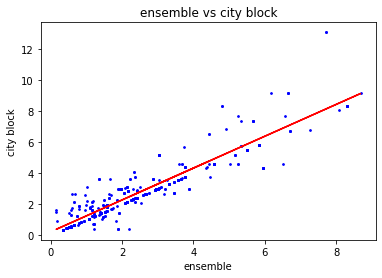

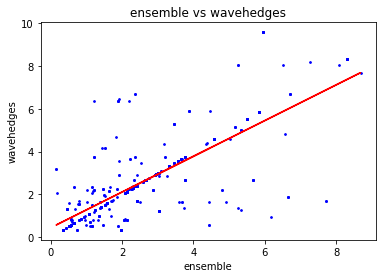

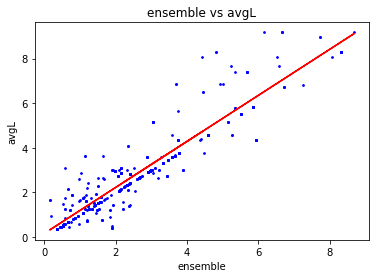

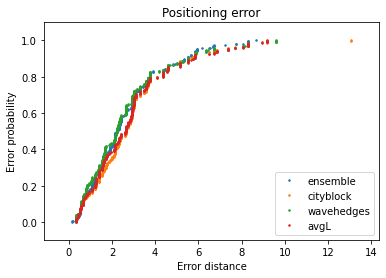

In [24]:
print("Median error ensemble MAN2: {}".format(median(ens)))
print("Median error city block MAN2: {}".format(median(cb_e)))
print("Median error wavehedges MAN2: {}".format(median(wav_e)))
print("Median error avgL MAN2: {}".format(median(avg_e)))

scatter(ens, cb_e, "ensemble vs city block", "ensemble", "city block")
scatter(ens, wav_e, "ensemble vs wavehedges", "ensemble", "wavehedges")
scatter(ens, avg_e, "ensemble vs avgL", "ensemble", "avgL")
plot_ecdf("Positioning error", 1, ["ensemble", "cityblock", "wavehedges", "avgL"], ens, cb_e, wav_e, avg_e)

### (!!!!) Distance measures comparison on SIM001 average error with k=1

#### Basic

In [ ]:
k=1
print_postitioning_errors(k, "SIM001", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 3.37
minkowskiL1: 3.41
minkowskiL2: 3.37
minkowskiL3: 3.42
minkowskiL4: 3.45
minkowskiL5: 3.45
cityblock: 3.41
chebyshev: 3.51
sorensen: 6.72
gower: 3.41


#### Normalized

In [4]:
k=1
print_postitioning_errors(k, "SIM001", distance_metrics, norm=True, abs_value=False, increment=False)

euclidean: 3.39
minkowskiL1: 2.89
minkowskiL2: 3.39
minkowskiL3: 3.54
minkowskiL4: 3.59
minkowskiL5: 3.61
cityblock: 2.89
chebyshev: 6.98
sorensen: 14.0
gower: 2.89
soergel: 2.92
kulczynski_d: 2.92
lorentzian: 2.89
canberra: 2.95
intersection: 2.89
wavehedges: 2.62
czekanowski_s: 2.92
czekanowski_d: 23.62
motyka_s: 2.92
motyka_d: 23.62
kulczynski_s: 2.92
ruzicka: 2.92
tanimoto: 2.92
inner: 20.39
harmonic: 8.6
cosine: 3.29
kumar: 28.31
jaccard_s: 28.31
jaccard_d: 22.05
dice_s: 3.37
dice_d: 23.0
fidelity: 19.0
bhattacharrya: 11.95


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:386: RuntimeWarning: invalid value encountered in sqrt
  "def kulczynski_d(P, Q):\n",


hellinger: 31.2
hellinger2: 3.31


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:394: RuntimeWarning: invalid value encountered in sqrt
  "\n",


matusita: 31.2
matusita2: 3.31
squared_chord: 3.31
sqeuclidean: 3.39
pearson: 3.87
neyman: 3.45
squared: 3.02
prob_sym: 3.02
divergence: 3.45
clark: 3.45
additive_sym: 4.83
kullback_PQ: 10.07
jeffreys: 3.52
k_divergence: 11.91
topsoe: 3.19
jensen_shannon: 3.19
jensen_diff: 3.19
taneja: 3.44
kumar_johnson: 5.06
avgL: 2.85
vicis_wave_hedges: 3.78
vicis_symm1: 5.61
vicis_symm2: 5.19
vicis_symm3: 2.86
min_symm: 3.05
max_symm: 4.88


#### Absolute value

In [5]:
k=1
print_postitioning_errors(k, "SIM001", distance_metrics, norm=False, abs_value=True, increment=False)

euclidean: 2.35
minkowskiL1: 2.43
minkowskiL2: 2.35
minkowskiL3: 2.35
minkowskiL4: 2.32
minkowskiL5: 2.28
cityblock: 2.43
chebyshev: 8.21
sorensen: 18.28
gower: 2.43
soergel: 2.44
kulczynski_d: 2.44
lorentzian: 2.56
canberra: 2.46
intersection: 2.43
wavehedges: 2.45
czekanowski_s: 2.44
czekanowski_d: 33.45
motyka_s: 2.44
motyka_d: 33.45
kulczynski_s: 2.44
ruzicka: 2.44
tanimoto: 2.44
inner: 18.8
harmonic: 12.0
cosine: 2.36
kumar: 2.33
jaccard_s: 2.33
jaccard_d: 37.63
dice_s: 2.33
dice_d: 37.63
fidelity: 18.44
bhattacharrya: 13.14


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:386: RuntimeWarning: invalid value encountered in sqrt
  "def kulczynski_d(P, Q):\n",


hellinger: 31.2
hellinger2: 2.36


C:\Users\vicen\Documents\Ciencia de dades\Q3\TFM\PAC3 disseny i implementacio\knn_lib.ipynb:394: RuntimeWarning: invalid value encountered in sqrt
  "\n",


matusita: 31.2
matusita2: 2.36
squared_chord: 2.36
sqeuclidean: 2.35
pearson: 2.38
neyman: 2.34
squared: 2.36
prob_sym: 2.36
divergence: 2.35
clark: 2.35
additive_sym: 2.36
kullback_PQ: 12.0
jeffreys: 2.36
k_divergence: 13.03
topsoe: 2.36
jensen_shannon: 2.36
jensen_diff: 2.36
taneja: 2.36
kumar_johnson: 2.36
avgL: 2.42
vicis_wave_hedges: 2.45
vicis_symm1: 2.35
vicis_symm2: 2.36
vicis_symm3: 2.35
min_symm: 2.36
max_symm: 2.36


#### Increment value

In [6]:
k=1
print_postitioning_errors(k, "SIM001", distance_metrics, norm=False, abs_value=False, increment=True)

euclidean: 3.26
minkowskiL1: 2.8
minkowskiL2: 3.26
minkowskiL3: 3.4
minkowskiL4: 3.39
minkowskiL5: 3.37
cityblock: 2.8
chebyshev: 8.32
sorensen: 18.28
gower: 2.8
soergel: 2.9
kulczynski_d: 2.9
lorentzian: 2.74
canberra: 2.88
intersection: 2.8
wavehedges: 2.83
czekanowski_s: 2.9
czekanowski_d: 23.61
motyka_s: 2.9
motyka_d: 23.61
kulczynski_s: 2.9
ruzicka: 2.9
tanimoto: 2.9
inner: 19.65
harmonic: 8.27
cosine: 3.24
kumar: 3.33
jaccard_s: 3.33
jaccard_d: 23.14
dice_s: 3.33
dice_d: 23.14
fidelity: 16.55
bhattacharrya: 10.28
hellinger: 31.2
hellinger2: 3.25
matusita: 31.2
matusita2: 3.25
squared_chord: 3.25
sqeuclidean: 3.26
pearson: 3.95
neyman: 3.15
squared: 3.08
prob_sym: 3.08
divergence: 3.02
clark: 3.02
additive_sym: 3.36
kullback_PQ: 8.42
jeffreys: 3.27
k_divergence: 10.07
topsoe: 3.21
jensen_shannon: 3.21
jensen_diff: 3.21
taneja: 3.29
kumar_johnson: 3.38
avgL: 2.81
vicis_wave_hedges: 3.29
vicis_symm1: 4.97
vicis_symm2: 3.36
vicis_symm3: 2.93
min_symm: 3.62
max_symm: 3.27


### Ensemble of different distance metrics

In [2]:
avg_error_ensemble(1, "DSI1", ["euclidean", "cityblock", "gower","canberra"], norm=False, abs_value=False, increment=False)

6.29